In [1]:
# toc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

plt.style.use('../maroon_ipynb.mplstyle')

cancer = load_breast_cancer()
features = cancer.data
target = cancer.target

# Problem 1
The sklearn library includes a set of data containing image information on fine needle aspirates used to
identify breast cancer. The dataset contains information gathered from the images as well as whether the
mass was malignant (target=0) or benign (target=1). The included python template shows how to make
arrays of the features and targets.

What is the split of malignant vs benign for the dataset? What issues might you forsee using a dataset with this split?

## Solution

In [2]:
benign = np.where(target == 1)
malignant = np.where(target == 0)

benign_count = len(benign[0])
malignant_count = len(malignant[0])
total = len(target)

assert benign_count + malignant_count == total

benign_ratio = benign_count/total
malignant_ratio = malignant_count/total
print(f'Benign: {benign_ratio:.2%} ({benign_count})')
print(f'Malignant: {malignant_ratio:.2%} ({malignant_count})')

Benign: 62.74% (357)
Malignant: 37.26% (212)


Though it is not severe, the imbalance between benign and malignant cases might cause issues. The dataset’s imbalance, with benign samples making up about 63% and malignant samples about 37%, could cause a machine learning model to favor predicting the benign class. This bias may lead to underperformance in identifying malignant cases, which is particularly concerning in medical diagnostics where both classes are critical.

# Problem 2
Generate a support vector classifier (SVC) to determine if the input data indicates a malignant or benign cancer. Use the linear kernel and varying values of C. Plot the accuracy score as a function of C. Use cross validation. What value of C gives the best results?

## Solution
First off, let's understand what data we are dealing with. The features data looks like this:

In [3]:
feature_names = cancer.feature_names
temp_df = pd.DataFrame(features, columns=feature_names)
temp_df.head(n=4).transpose()

,0,1,2,3
mean radius,17.990000,20.570000,19.690000,11.420000
mean texture,10.380000,17.770000,21.250000,20.380000
mean perimeter,122.800000,132.900000,130.000000,77.580000
mean area,1001.000000,1326.000000,1203.000000,386.100000
mean smoothness,0.118400,0.084740,0.109600,0.142500
mean compactness,0.277600,0.078640,0.159900,0.283900
mean concavity,0.300100,0.086900,0.197400,0.241400
mean concave points,0.147100,0.070170,0.127900,0.105200
mean symmetry,0.241900,0.181200,0.206900,0.259700
mean fractal dimension,0.078710,0.056670,0.059990,0.097440


This data needs to be normalized using the variance method.

In [4]:
pipline = make_pipeline(StandardScaler(), SVC(kernel='linear'))
scores = cross_val_score(pipline, features, target, cv=5)
scores

array([0.96491228, 0.98245614, 0.96491228, 0.96491228, 0.98230088])

In this snippet above, the model is normalized with the variance method, and an SVC model with the regularization parameter, `C`, is 1 by default. The `cross_val_score` function will divide the data into 5 parts, train the model on 4 parts, and test it on the 5th part. It will then record the accuracy over the testing portion of the data:

$$Accuracy=\frac{Correct\ Predictions}{Total\ Predictions}$$

It does this procedure of dividing 5 times, choosing a different 4/5 to train, and a different 1/5 to test. We can make a loop that will see how adjusting the `C` parameter will change the accuracy of the model.

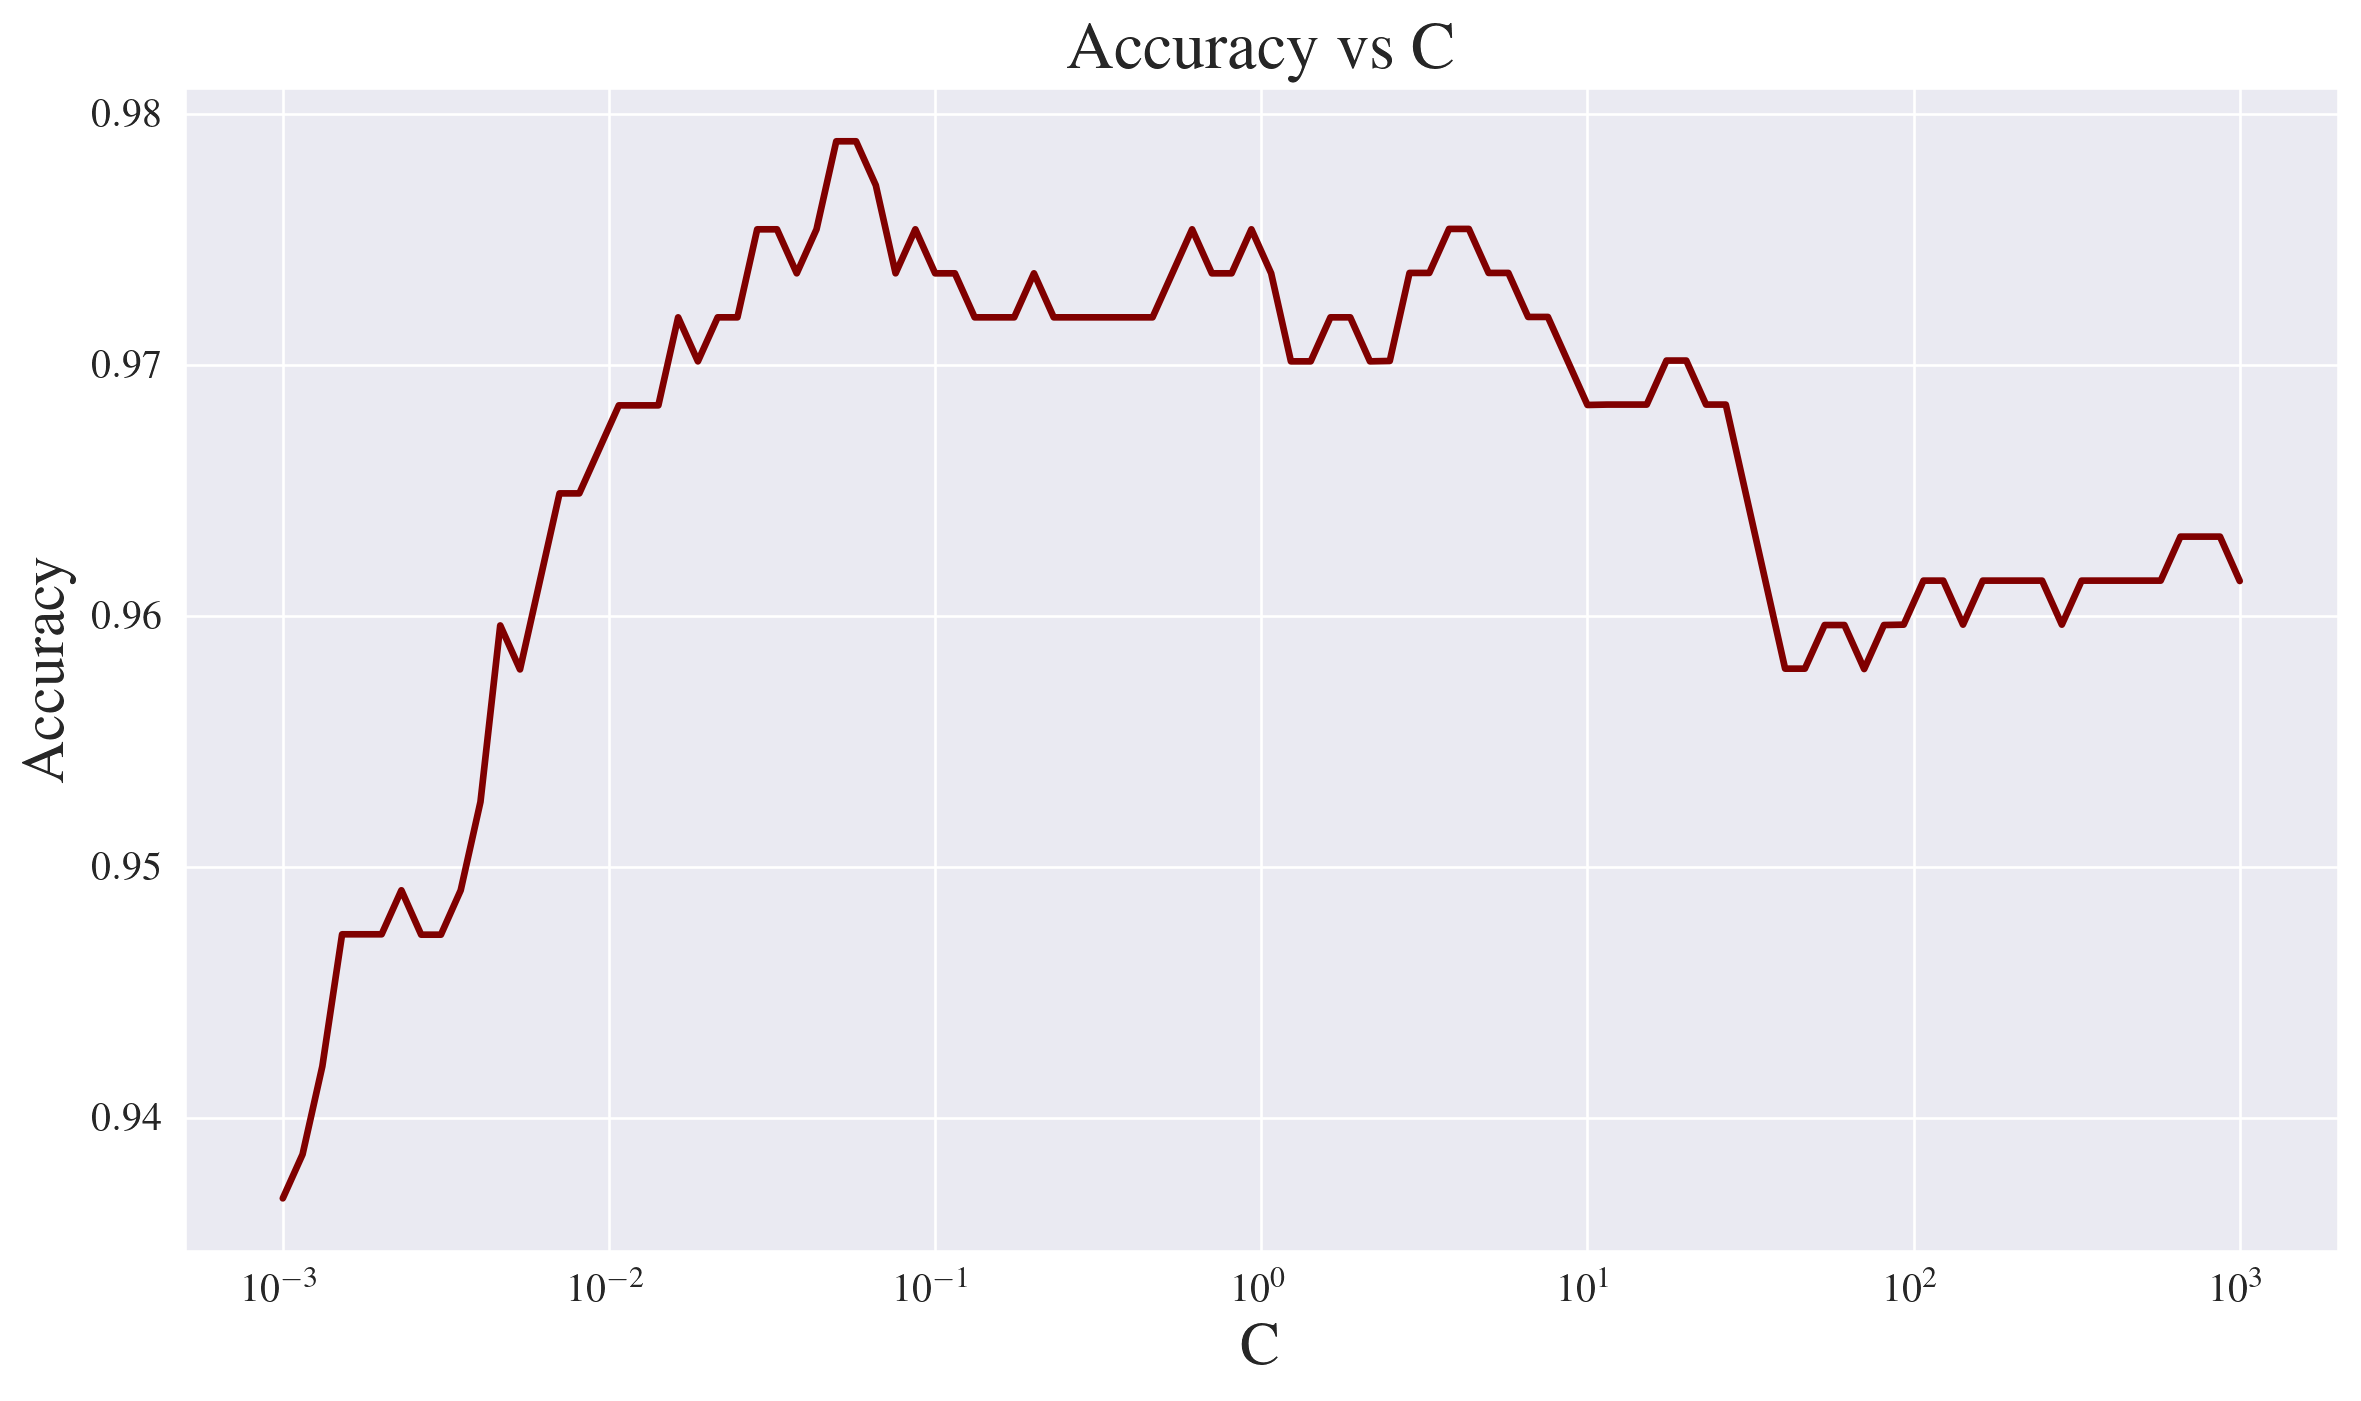

In [5]:
c_values = np.logspace(-3, 3, 100)  # use logspace to get a wider range of C values
cv_scores = []
for c in c_values:
    pipline = make_pipeline(StandardScaler(), SVC(kernel='linear', C=c))
    scores = cross_val_score(pipline, features, target, cv=5)
    cv_scores.append(np.mean(scores))

fig, ax = plt.subplots()
ax.semilogx(c_values, cv_scores)
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs C')
plt.show()

In [6]:
# Best C value
best_index = np.argmax(cv_scores)
best_c = c_values[best_index]
float(best_c)

0.049770235643321115

In [7]:
# the highest score
float(cv_scores[best_index])

0.9789163173420278

As seen above, a `C` value of around 0.05 gives the best results. You can even notice the overfitting that occurs after `C` values of around 30.

# Problem 3
Using the radial basis function kernel (RBF), determine the hyperparameters ($C$ and $\gamma$) that result in the best model.

## Solution
You can use the `GridSearchCV` class to find the best hyperparameters for the model.

In [8]:
pipline = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
N = 20
param_grid = {
    'svc__C': np.logspace(-3, 3, N),
    'svc__gamma': np.logspace(-3, 3, N)
}

grid_search = GridSearchCV(pipline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(features, target)

# Best parameters
grid_search.best_params_

{'svc__C': np.float64(6.158482110660261),
 'svc__gamma': np.float64(0.018329807108324356)}

In [9]:
# Best score
float(grid_search.best_score_)

0.9806862288464524

As seen above, the best parameters are $C=6.16$ and $\gamma=0.018$. These parameters result in a cross-validated accuracy score of 0.98. Here is a heatmap of the grid:

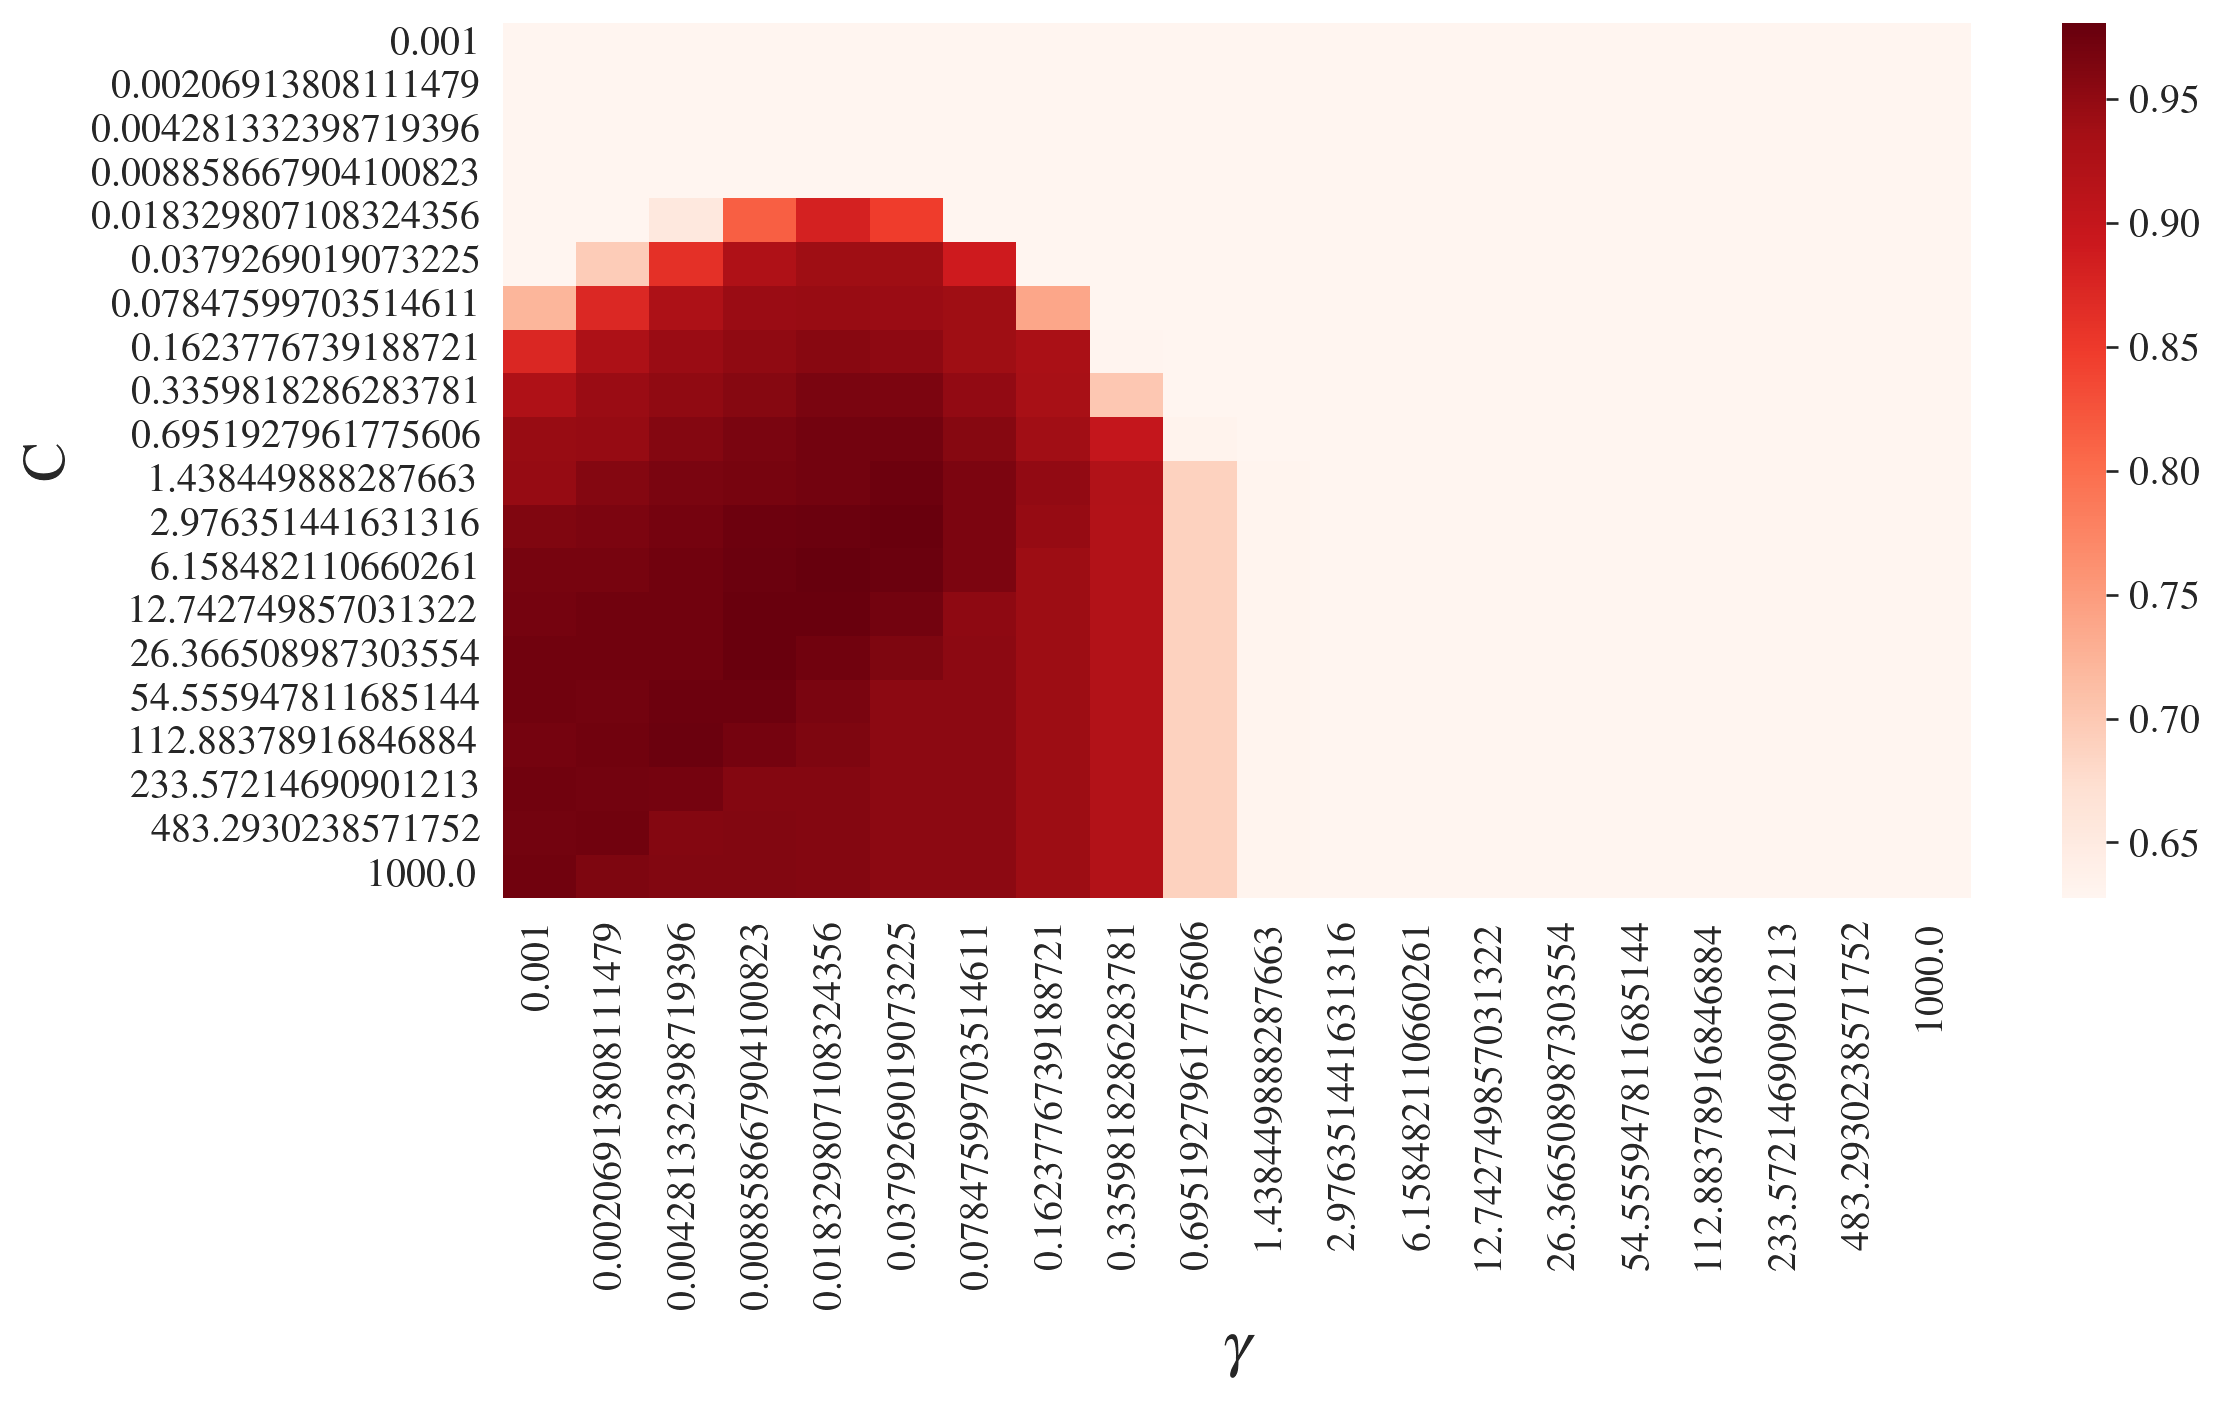

In [10]:
results_df = pd.DataFrame(grid_search.cv_results_)
scores_pivot = results_df.pivot(index='param_svc__C', columns='param_svc__gamma', values='mean_test_score')

fig, ax = plt.subplots()
sns.heatmap(scores_pivot, fmt='.3f', cmap='Reds')
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('C')
plt.show()

# Problem 4
Generate the most accurate SVC model you can (feel free to use other kernels and varying hyperparameters). What is the precision and recall of this model? Use a train/test split and give the precision and recall for the test data. Show the confusion matrix for both the training and test data.

## Solution
I'm going to redo the hyperparameter search using a finer grid around the best parameters found above.

In [11]:
pipline = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
N = 20
param_grid = {
    'svc__C': np.linspace(1, 10, N),
    'svc__gamma': np.linspace(0.005, 0.05, N)
}

grid_search = GridSearchCV(pipline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(features, target)

# Best parameters
grid_search.best_params_

{'svc__C': np.float64(4.789473684210526),
 'svc__gamma': np.float64(0.023947368421052634)}

In [12]:
# Best score
float(grid_search.best_score_)

0.9824561403508772

In [13]:
# Making a new model with this hyperparameter set
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
final_pipe = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=4.7895, gamma=0.02395))
final_pipe.fit(x_train, y_train)

y_pred = final_pipe.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')

Accuracy: 98.25%
Precision: 97.26%
Recall: 100.00%


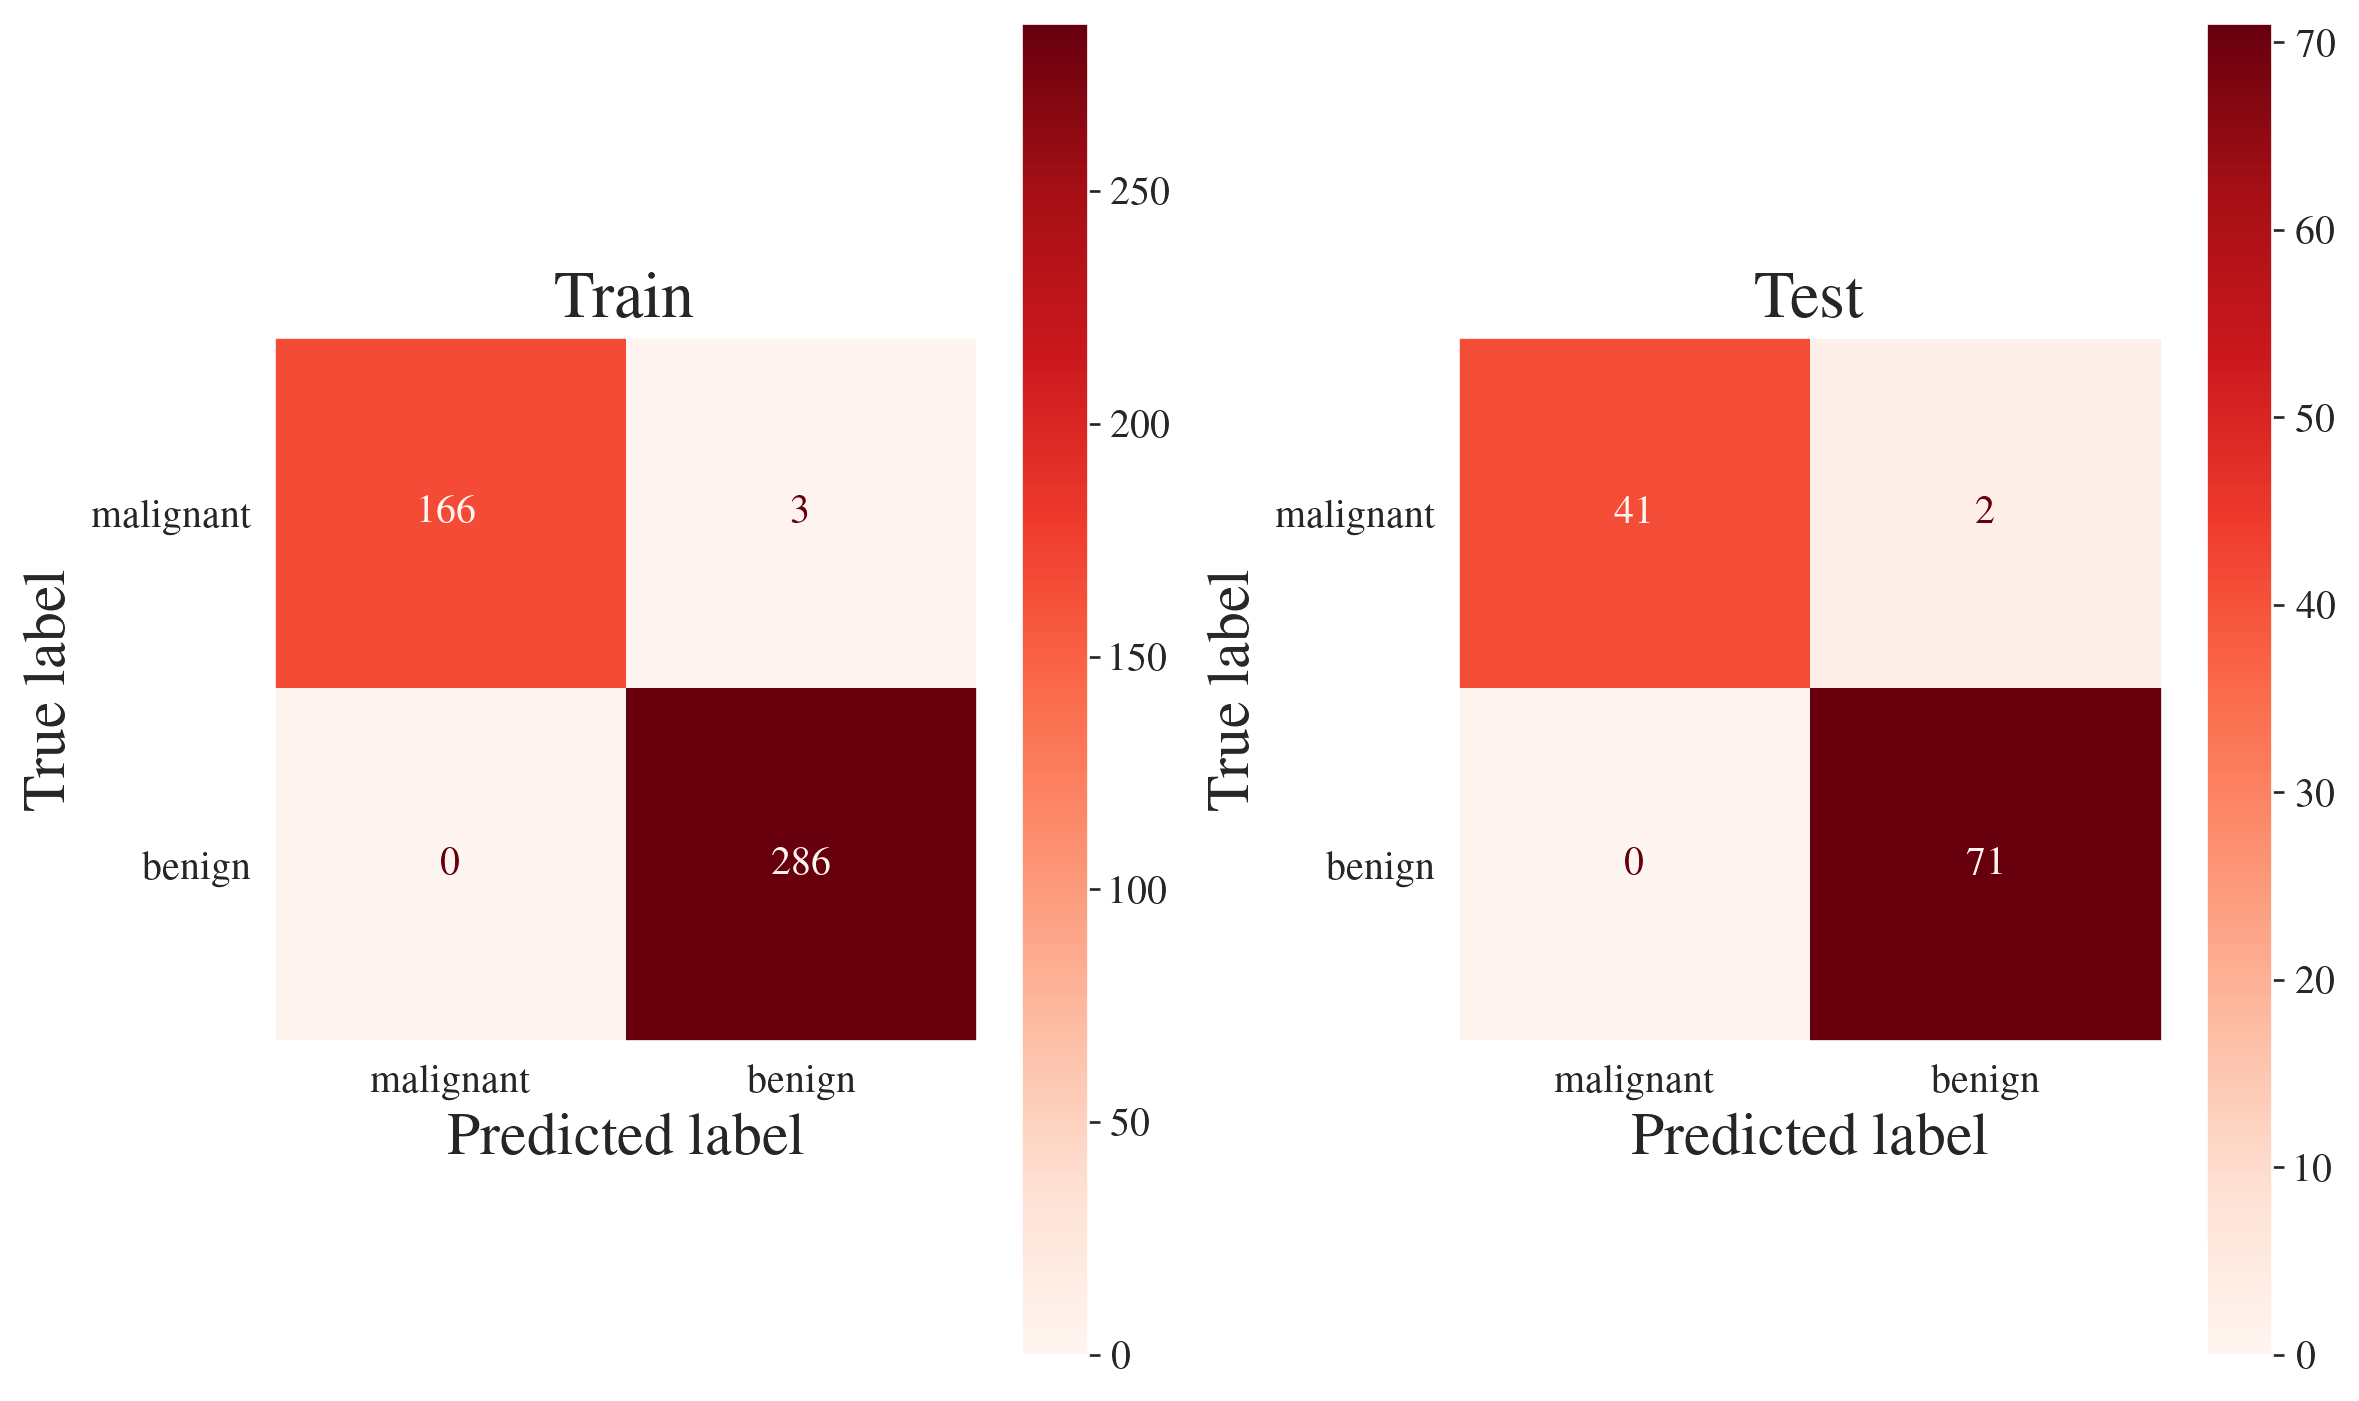

In [14]:
# Confusion matrix for test data
fig, ax = plt.subplots(ncols=2)
ConfusionMatrixDisplay.from_estimator(final_pipe, x_train, y_train, ax=ax[0], display_labels=cancer.target_names, cmap='Reds')
ConfusionMatrixDisplay.from_estimator(final_pipe, x_test, y_test, ax=ax[1], display_labels=cancer.target_names, cmap='Reds')
ax[0].set_title('Train')
ax[1].set_title('Test')
ax[0].grid(False)
ax[1].grid(False)
plt.show()

# Problem 5
If your trained model from question 4 is given a novel set of inputs and determines that the cancer is malignant, what is the chance that it is wrong? How does this relate to your answer for question 1?

## Solution
In the confusion matrices above, you can see that the malignant prediction for the test data is showing 0 predicted malignant cases and it actually being benign. This means that there is a zero percent chance that it will predict malignant and it be wrong. This relationship is defined as the precision with the positive class being malignant:

$$\%chance_{wrong}=1-Precision_{malignant}=1-\frac{Correct\ Malignant\ Predictions}{Total\ Malignant\ Predictions}$$

In relation to the first question, we predicted that the model would bias the benign cases because there were far more benign cases in the data. These results reflect this bias, and it is a bad bias because it is more dangerous to predict benign and it actually be malignant.

In [15]:
# You can do this to shift the positive class
# This would find the precision of the malignant class
malignant_precision = precision_score(y_test, y_pred, pos_label=0)
1 - malignant_precision

0.0

Question 4 asked to find the most accurate model, but this kind of accuracy is not what I would want in the model. I would prefer the model to have that 2 be in the bottom left of the confusion matrix to prevent predicting benign, and the cancer actually being malignant. We can adjust the weight to balance the dataset and find new hyperparameters.

In [16]:
W = 3
best_pipe = make_pipeline(StandardScaler(), SVC(kernel='rbf', class_weight={0: W, 1: 1}))
N = 20
param_grid = {
    'svc__C': np.logspace(-3, 3, N),
    'svc__gamma': np.logspace(-3, 3, N)
}
grid_search = GridSearchCV(best_pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit(features, target)

# Best parameters
grid_search.best_params_

{'svc__C': np.float64(2.976351441631316),
 'svc__gamma': np.float64(0.008858667904100823)}

In [17]:
# Best score
float(grid_search.best_score_)

0.9771464058376027

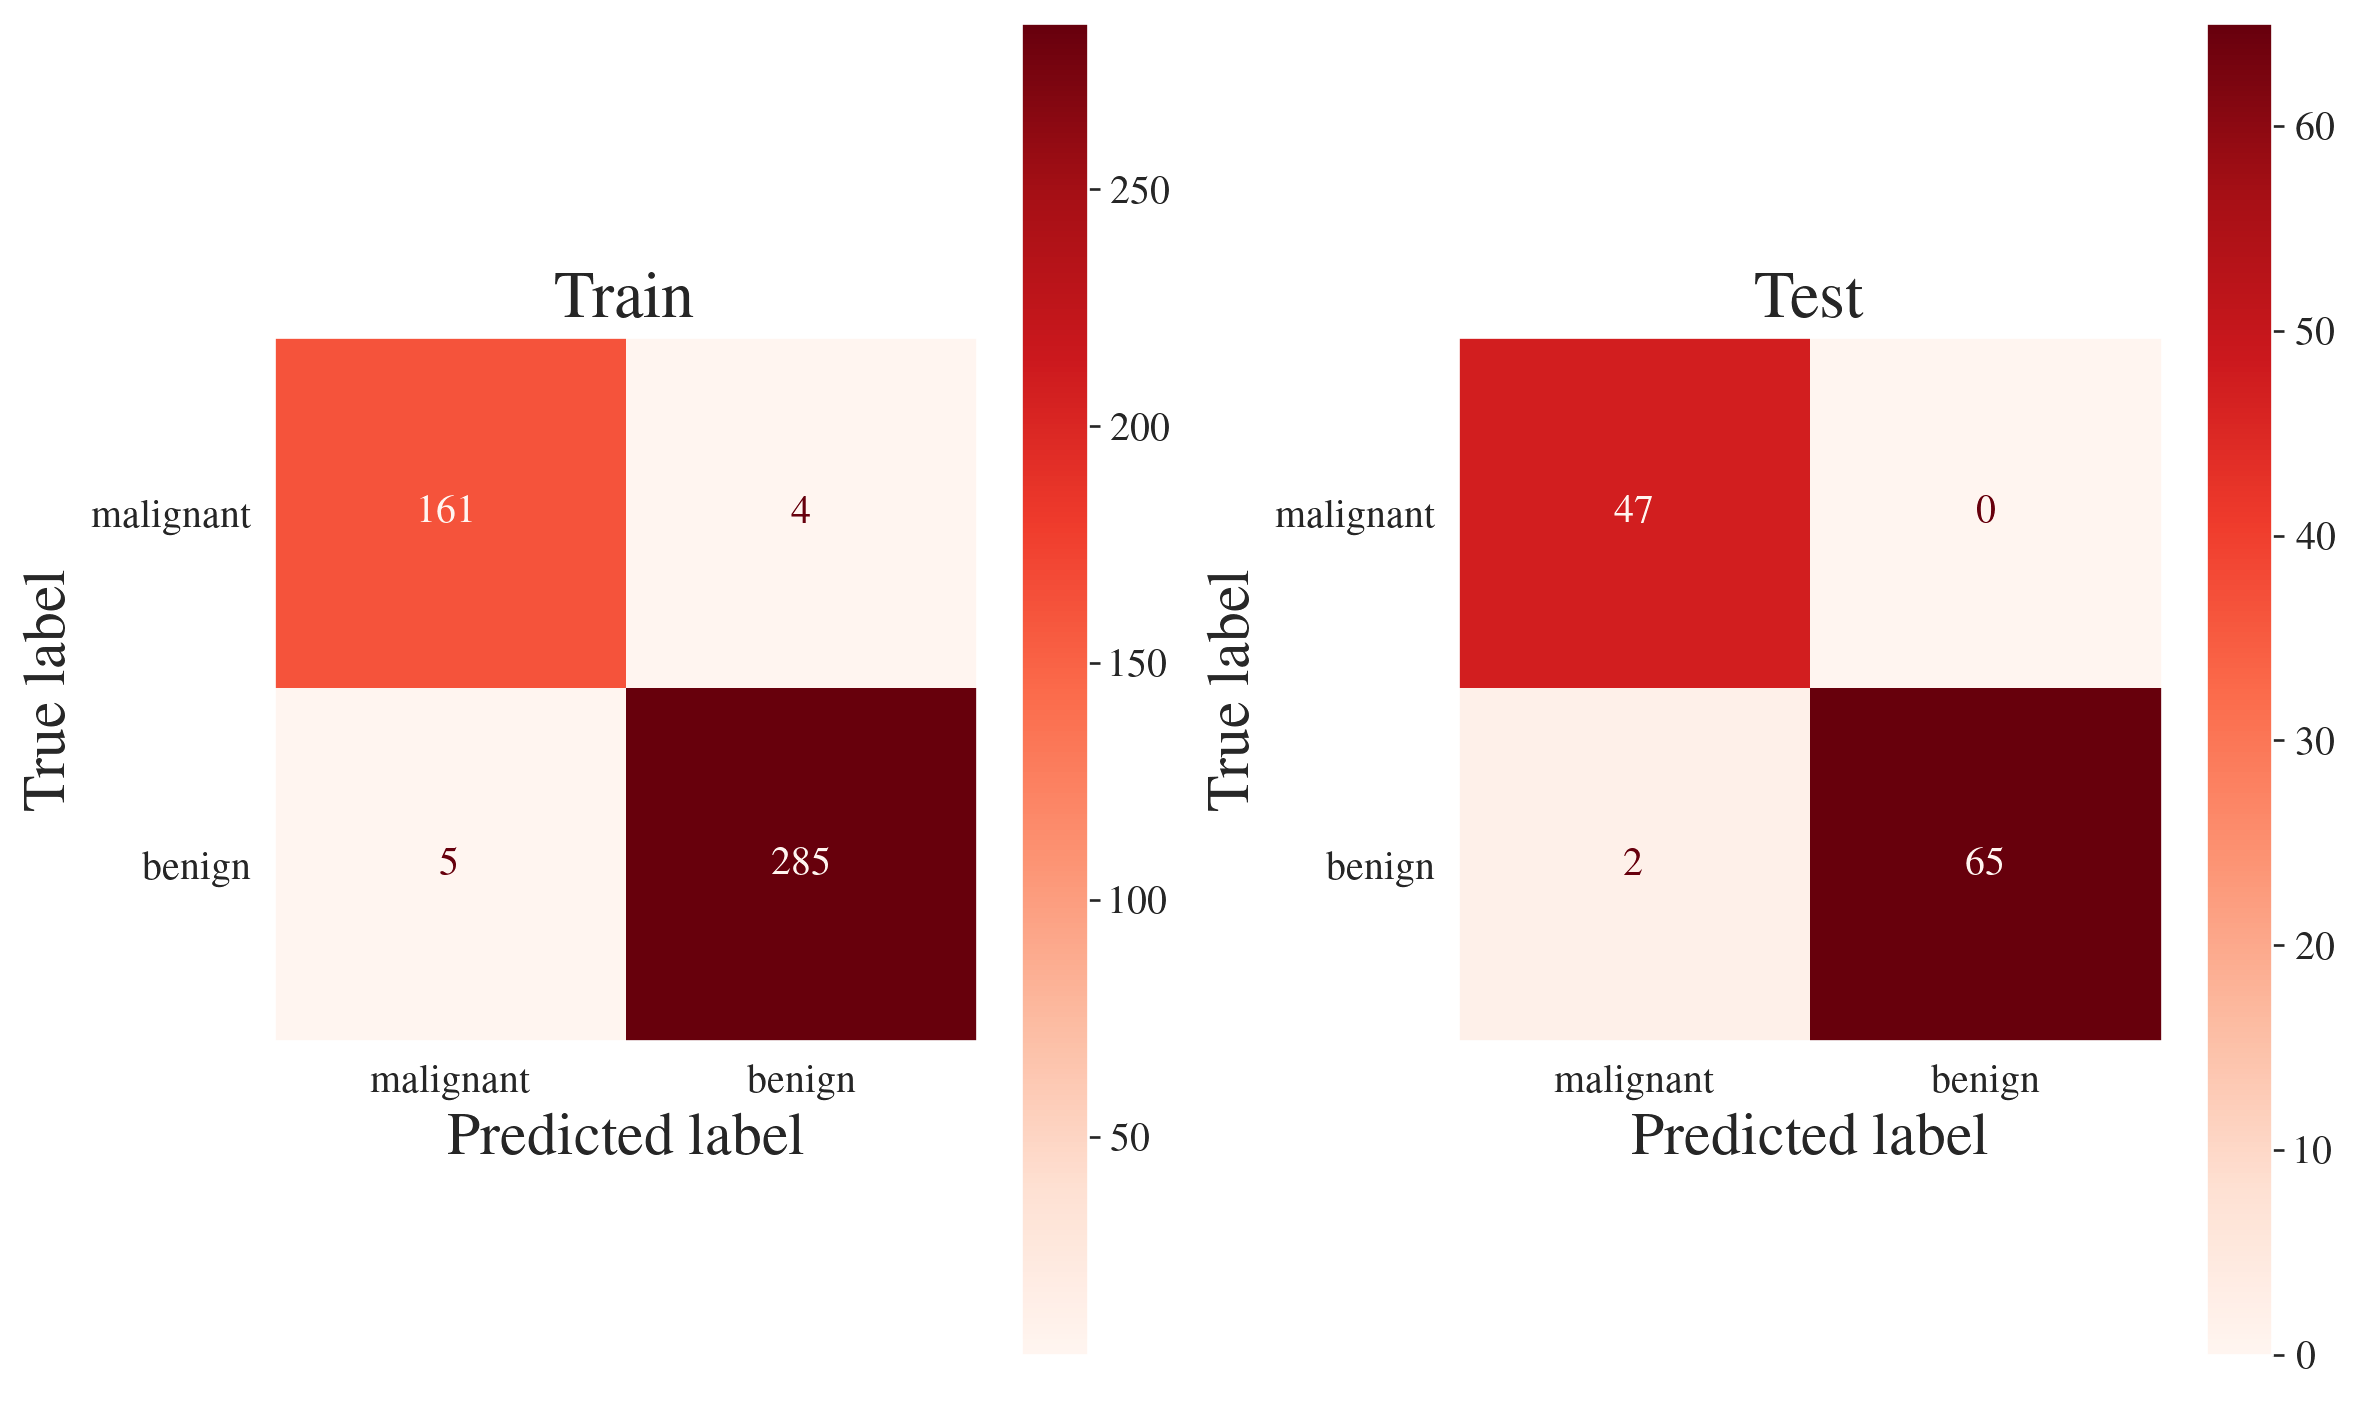

Accuracy: 98.25%
Precision: 100.00%
Recall: 97.01%


In [18]:
# Making a new confusion matrix
best_c = grid_search.best_params_['svc__C']
best_gamma = grid_search.best_params_['svc__gamma']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)
final_pipe = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=best_c, gamma=best_gamma, class_weight={0: W, 1: 1}))
final_pipe.fit(x_train, y_train)
y_pred = final_pipe.predict(x_test)

fig, ax = plt.subplots(ncols=2)
ConfusionMatrixDisplay.from_estimator(final_pipe, x_train, y_train, ax=ax[0], display_labels=cancer.target_names, cmap='Reds')
ConfusionMatrixDisplay.from_estimator(final_pipe, x_test, y_test, ax=ax[1], display_labels=cancer.target_names, cmap='Reds')
ax[0].set_title('Train')
ax[1].set_title('Test')
ax[0].grid(False)
ax[1].grid(False)
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')

I would prefer this model over the one done in question 4. The accuracy is about the same, but the added weight shifts the bias. With this new model, there would be a 4.08% chance of predicting malignant and it actually being benign.

In [19]:
malignant_precision = precision_score(y_test, y_pred, pos_label=0)
1 - malignant_precision

0.04081632653061229